# **Important Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Prepare Dataset**

In [2]:
def prepare_data(data_dir):
    
    filepaths = []
    labels = []
    
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            filepath = os.path.join(foldpath, file)
            filepaths.append(filepath)
            labels.append(fold)
    
    df = pd.DataFrame(data={'filepaths': filepaths, 'labels': labels})
    return df

In [3]:
data_dir = '/kaggle/input/militaryaircraftdetectiondataset/crop'
df = prepare_data(data_dir)
print(f'Shape of dataset is {df.shape}, numbers of labels {df["labels"].nunique()}')
df.head()

Shape of dataset is (34515, 2), numbers of labels 81


,filepaths,labels
0,/kaggle/input/militaryaircraftdetectiondataset...,CL415
1,/kaggle/input/militaryaircraftdetectiondataset...,CL415
2,/kaggle/input/militaryaircraftdetectiondataset...,CL415
3,/kaggle/input/militaryaircraftdetectiondataset...,CL415
4,/kaggle/input/militaryaircraftdetectiondataset...,CL415


In [4]:
train, test = train_test_split(df,test_size = 0.3,stratify = df['labels'],random_state = 42)
test, valid = train_test_split(test,test_size = 0.5,stratify = test['labels'],random_state = 42)
train.shape, test.shape, valid.shape

((24160, 2), (5177, 2), (5178, 2))

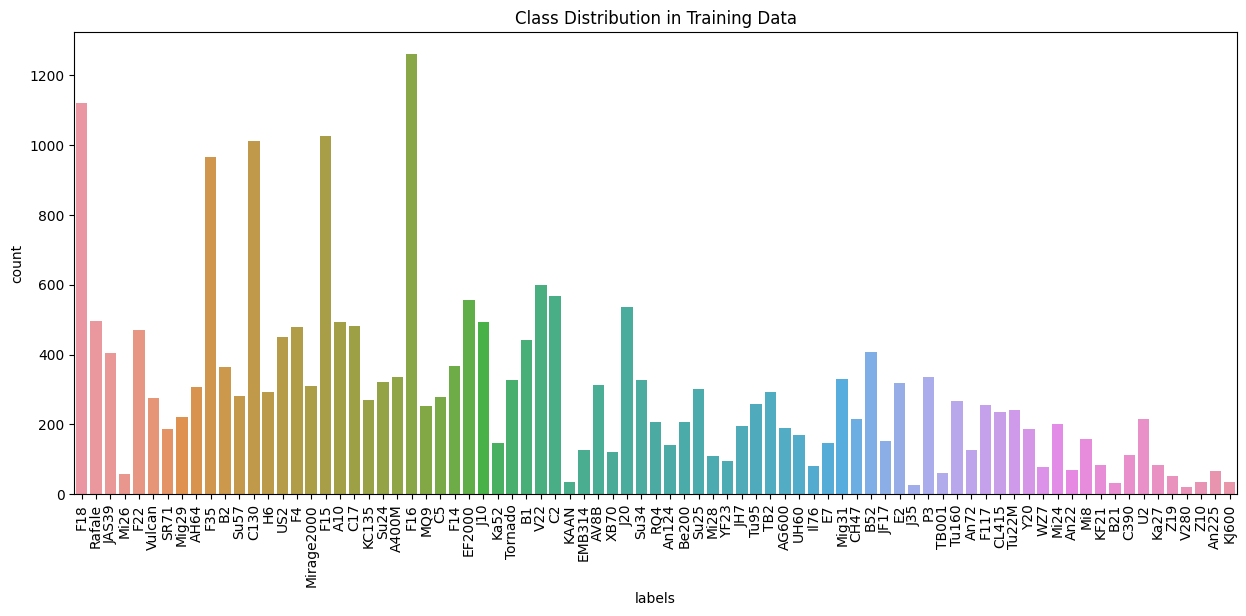

In [5]:
# Class Distribution
plt.figure(figsize=(15, 6))
sns.countplot(data=train, x='labels')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=90)
plt.show()

In [6]:
batch_size = 16
img_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe( 
    train, 
    x_col= 'filepaths',
    y_col= 'labels', 
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

valid_gen = gen.flow_from_dataframe(
    valid, 
    x_col= 'filepaths', 
    y_col= 'labels', 
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb', 
    shuffle= False, 
    batch_size= batch_size
)

test_gen = gen.flow_from_dataframe(
    test,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb', 
    shuffle= False, 
    batch_size= batch_size
)

Found 24160 validated image filenames belonging to 81 classes.
Found 5178 validated image filenames belonging to 81 classes.
Found 5177 validated image filenames belonging to 81 classes.


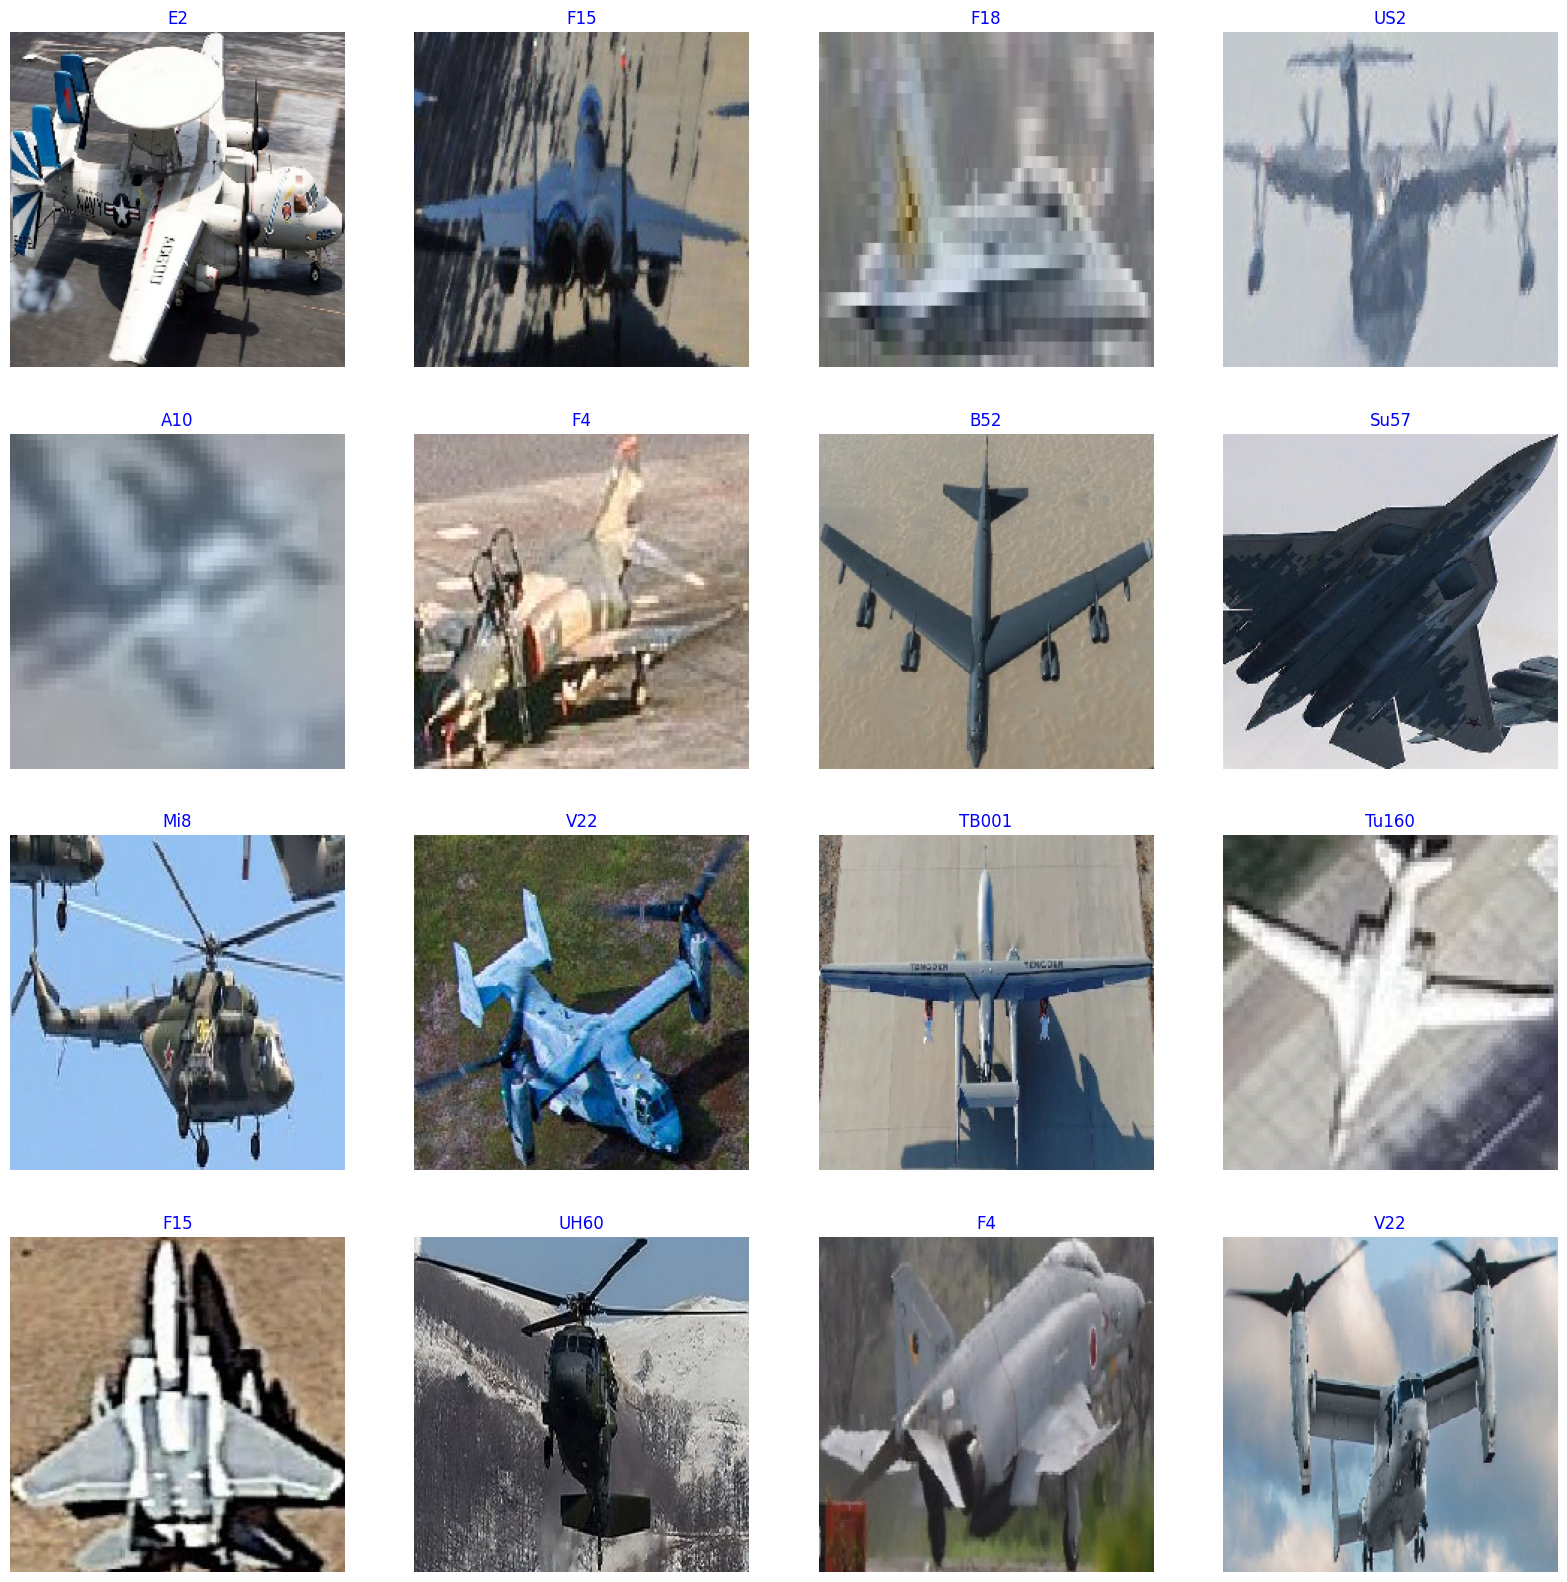

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255 
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model**

In [8]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

# Load EfficientNetB3 pre-trained on ImageNet
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape,
    pooling="max"
)

model = Sequential([
    base_model,
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dropout(0.3),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 81)                  │          20,817 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,197,824 (42.72 MB)

 Trainable params: 11,110,521 (42.38 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [9]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen, 
    epochs=20, 
    validation_data=valid_gen, 
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1510/1510 ━━━━━━━━━━━━━━━━━━━━ 521s 276ms/step - accuracy: 0.0928 - loss: 4.2124 - val_accuracy: 0.4679 - val_loss: 2.1749
Epoch 2/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 220s 145ms/step - accuracy: 0.4686 - loss: 2.1573 - val_accuracy: 0.7072 - val_loss: 1.1772
Epoch 3/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 220s 145ms/step - accuracy: 0.7006 - loss: 1.1426 - val_accuracy: 0.7820 - val_loss: 0.8719
Epoch 4/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 220s 145ms/step - accuracy: 0.8109 - loss: 0.6860 - val_accuracy: 0.8185 - val_loss: 0.7417
Epoch 5/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 219s 145ms/step - accuracy: 0.8718 - loss: 0.4579 - val_accuracy: 0.8188 - val_loss: 0.7452
Epoch 6/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 220s 146ms/step - accuracy: 0.9071 - loss: 0.3232 - val_accuracy: 0.8405 - val_loss: 0.7311
Epoch 7/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 219s 145ms/step - accuracy: 0.9339 - loss: 0.2314 - val_accuracy: 0.8482 - val_loss: 0.6787
Epoch 8/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 220s 145ms/step - accuracy: 0.9

# **Evaluate the Model**

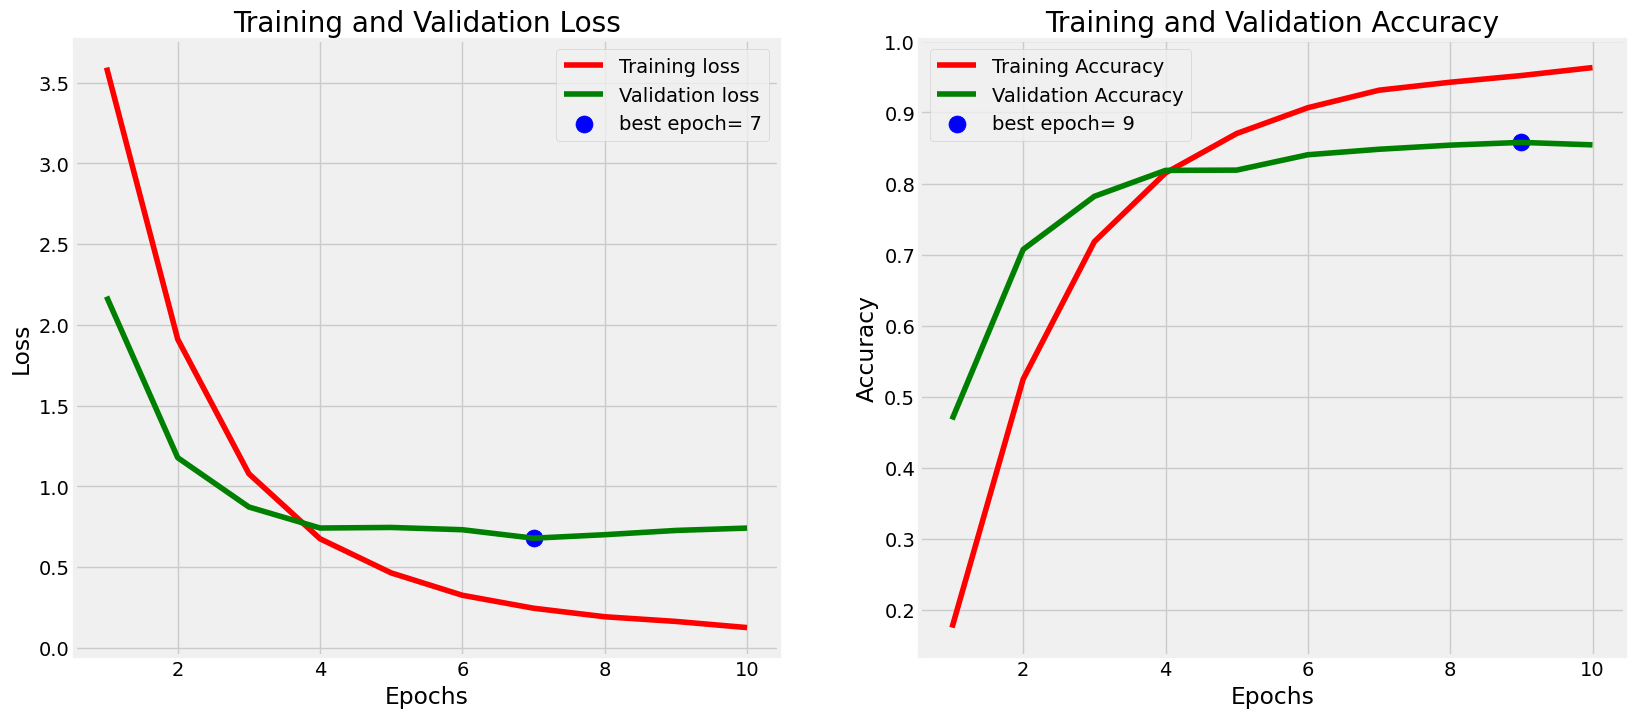

In [10]:
# Plot Accuracy and Loss
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [11]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1510/1510 ━━━━━━━━━━━━━━━━━━━━ 113s 75ms/step - accuracy: 0.9912 - loss: 0.0323
324/324 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.8443 - loss: 0.6925
  1/324 ━━━━━━━━━━━━━━━━━━━━ 55s 172ms/step - accuracy: 0.7500 - loss: 0.4824

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 85s 263ms/step - accuracy: 0.8401 - loss: 0.6990
Train Loss:  0.03461477532982826
Train Accuracy:  0.990562915802002
--------------------
Validation Loss:  0.6787366271018982
Validation Accuracy:  0.8482039570808411
--------------------
Test Loss:  0.7096243500709534
Test Accuracy:  0.8446977138519287


In [12]:
# Get Predictions
preds = model.predict(test_gen) 
y_pred = np.argmax(preds, axis=1) 
g_dict = test_gen.class_indices 
classes = list(g_dict.keys())

324/324 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step


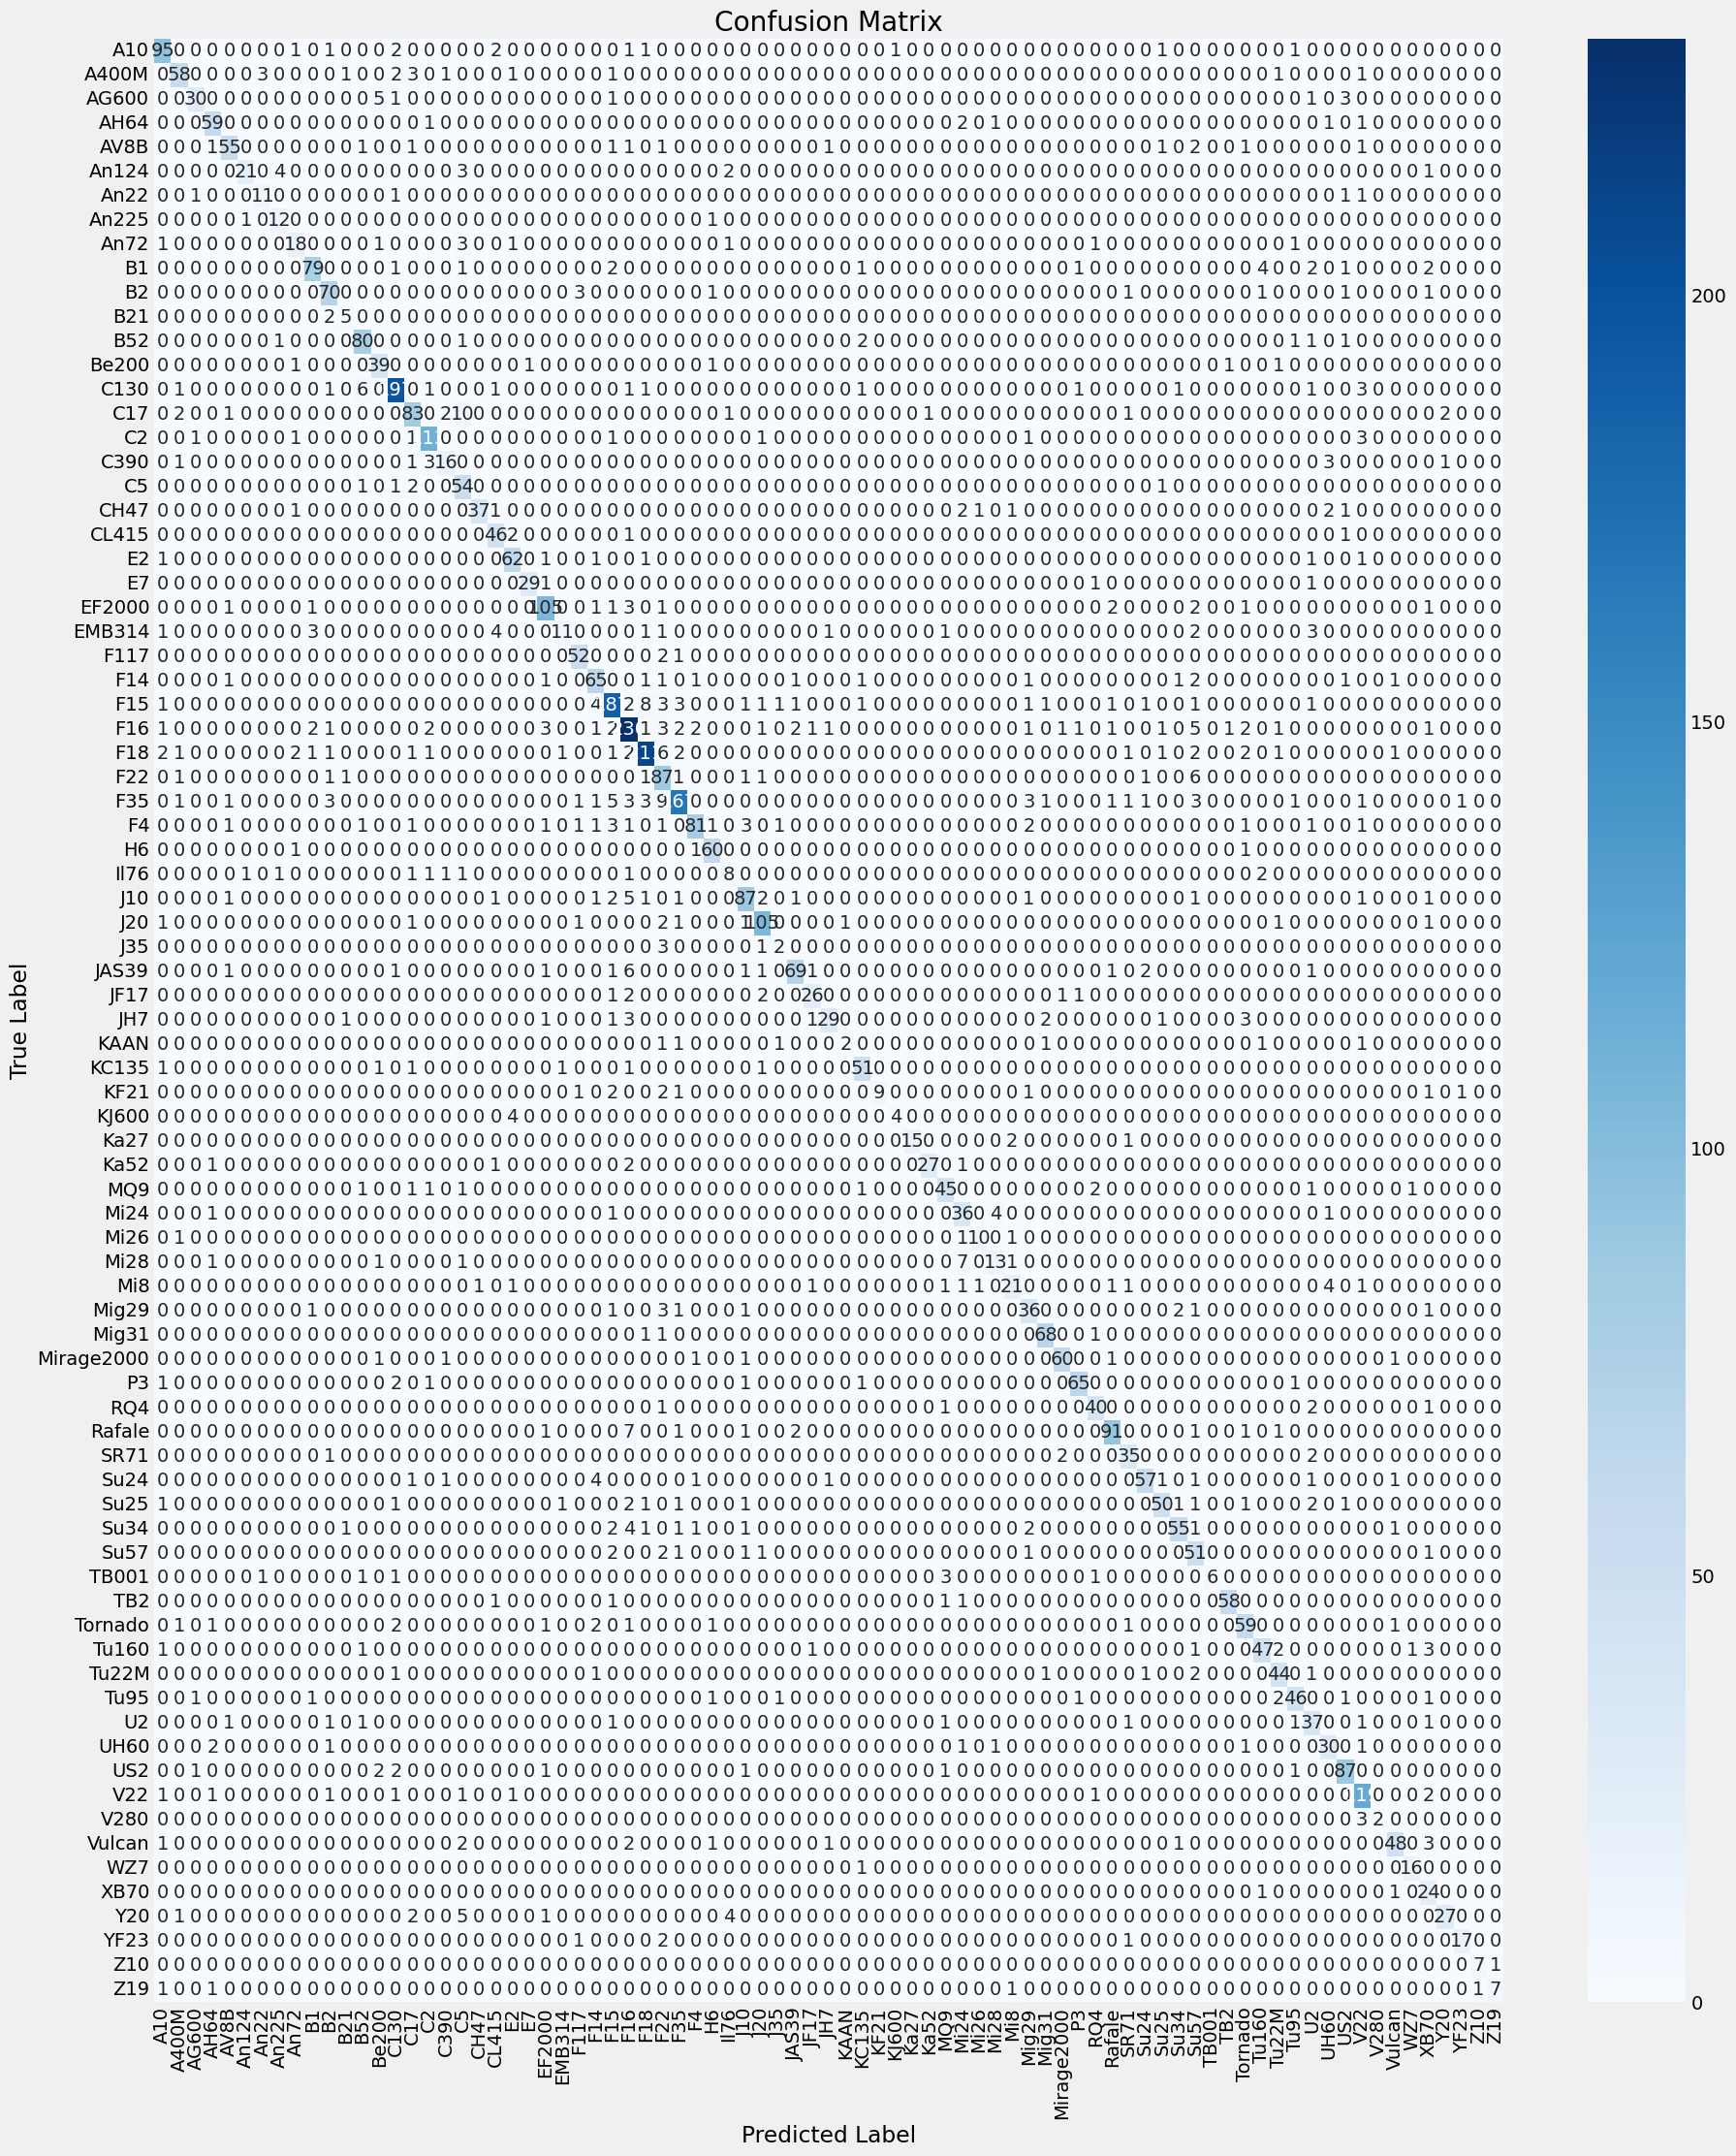

In [16]:
# Confusion Matrix
plt.figure(figsize=(20, 25))
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         A10       0.86      0.90      0.88       106
       A400M       0.85      0.81      0.83        72
       AG600       0.88      0.73      0.80        41
        AH64       0.87      0.91      0.89        65
        AV8B       0.87      0.82      0.85        67
       An124       0.91      0.68      0.78        31
        An22       0.73      0.73      0.73        15
       An225       0.67      0.86      0.75        14
        An72       0.72      0.67      0.69        27
          B1       0.90      0.84      0.87        94
          B2       0.83      0.90      0.86        78
         B21       0.56      0.71      0.63         7
         B52       0.86      0.92      0.89        87
       Be200       0.78      0.89      0.83        44
        C130       0.91      0.91      0.91       216
         C17       0.83      0.81      0.82       103
          C2       0.91      0.93      0.92       122
        C390       0.73    

# **Save Model**

In [17]:
model.save('military_aircraft_classification.h5')